# Setup
First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [7]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Load up MNIST data set for Training and Testing/Test/Validation

In [8]:

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [15]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

Let's build a neural net for MNIST, using the ELU activation function and Batch Normalization at each layer:

In [22]:
from functools import partial

reset_graph()
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 300
n_hidden3 = 100
n_outputs = 10
learning_rate = 0.01
batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    hidden3 = my_dense_layer(bn2, n_hidden3, name="hidden3")
    bn3 = tf.nn.elu(my_batch_norm_layer(hidden3))
    logits_before_bn = my_dense_layer(bn3, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [48]:
n_epochs = 10
batch_size = 200
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Val accuracy:", acc_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.905 Val accuracy: 0.9096
1 Batch accuracy: 0.905 Val accuracy: 0.93
2 Batch accuracy: 0.95 Val accuracy: 0.941
3 Batch accuracy: 0.94 Val accuracy: 0.95
4 Batch accuracy: 0.96 Val accuracy: 0.9552
5 Batch accuracy: 0.935 Val accuracy: 0.9588
6 Batch accuracy: 0.985 Val accuracy: 0.9634
7 Batch accuracy: 0.965 Val accuracy: 0.9642
8 Batch accuracy: 0.975 Val accuracy: 0.967
9 Batch accuracy: 0.98 Val accuracy: 0.9692


In [24]:
from tensorflow_graph_in_jupyter import show_graph
show_graph(tf.get_default_graph())


# Let's look at predictions


In [62]:
pred_size = 200 #keep in mind this is re-using data from test set

with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = X_test[:pred_size]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [63]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", y_test[:pred_size])

Predicted classes: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 2 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9 6 0 5 4 9 9 2 1 9 4 8
 7 3 9 7 4 4 4 9 2 5 4 7 6 7 9 0 5 8 5 6 6 5 7 8 1 0 1 6 4 6 7 3 1 7 1 8 2
 0 9 9 9 5 5 1 5 6 0 3 4 4 6 5 4 6 5 4 5 1 4 4 7 2 3 2 7 1 8 1 8 1 8 5 0 8
 9 2 5 0 1 1 1 0 3 0 3 1 6 4 2]
Actual classes:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9 6 0 5 4 9 9 2 1 9 4 8
 7 3 9 7 4 4 4 9 2 5 4 7 6 7 9 0 5 8 5 6 6 5 7 8 1 0 1 6 4 6 7 3 1 7 1 8 2
 0 2 9 9 5 5 1 5 6 0 3 4 4 6 5 4 6 5 4 5 1 4 4 7 2 3 2 7 1 8 1 8 1 8 5 0 8
 9 2 5 0 1 1 1 0 9 0 3 1 6 4 2]


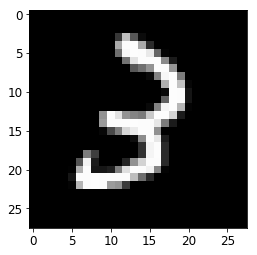

has been classified as  2 and should be  3


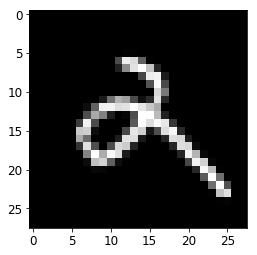

has been classified as  9 and should be  2


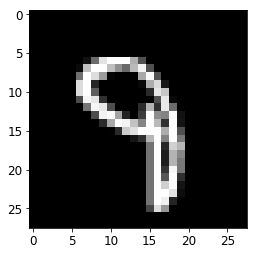

has been classified as  3 and should be  9


In [64]:
import matplotlib.pyplot as plt
for input, prediction, label in zip(X_test, y_pred, y_test):
  if prediction != label:
    
    plotData = input
    plotData = plotData.reshape(28, 28)
    plt.gray() # use this line if you don't want to see it in color
    plt.imshow(plotData)
    plt.show()
    print('has been classified as ', prediction, 'and should be ', label) 
    

In [66]:
from sklearn import metrics

my_matrix = metrics.confusion_matrix(y_test[:pred_size], y_pred)
print(my_matrix)

[[17  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0  0  1]
 [ 0  0  1 15  0  0  0  0  0  0]
 [ 0  0  0  0 28  0  0  0  0  0]
 [ 0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0]
 [ 0  0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  1  0  0  0  0  0 20]]
